In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
import wispy.waveutils
import wispy.model_utils

In [3]:
model_amp = tf.keras.models.load_model("amplitude_210330_ugngmn9d/model.h5", compile=False)
model_phase = tf.keras.models.load_model("phase_210330_xon70_fh/model.h5", compile=False)

In [4]:
model_amp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 4150)              2128950   
Total params: 2,197,222
Trainable params: 2,197,222
Non-trainable params: 0
_________________________________________________________________


In [5]:
def ann_wf(q, n):
    """
    q: mass-ratio
    n: model float index
        0: IMRPhenomC
        1: IMRPhenomD
        2: NR
        3: SEOBNRv4_opt
    """

In [6]:
tc = 2001.
amp_scale = 1.88
phase_scale = -929.68

In [7]:
dt = 0.5
t_min = -2000.0
t_max = 75.0

In [8]:
times = np.arange(t_min, t_max, dt)

In [9]:
def predict_wave(n, q, tc=tc, amp_scale=amp_scale, phase_scale=phase_scale, model_amp=model_amp, model_phase=model_phase, times=times, scale_data=True):
    """
    qs: 1d array of mass-ratios
    ns: 1d array of model numbers ranging from 0 to 2, inclusive
    """
    
    q = np.atleast_1d(q)
    n = np.atleast_1d(n)
    
#     print(n, q)
    
    inputs = np.column_stack((n, q))
    
#     print(inputs)
    
    amp = model_amp.predict(inputs)
    phase = model_phase.predict(inputs)
    
    eta = phenom.eta_from_q(q)[:,np.newaxis]
    
    if scale_data:
        t3_leading = wispy.waveutils.taylorT3_leading_term(times, eta, tc)
        phase = phase * t3_leading
        phase = phase * phase_scale
        amp = amp * amp_scale * eta
    
    
    h = amp * np.exp(-1.j*phase)
#     return np.real(h)
    return h, amp, phase

In [10]:
h, amp, phase = predict_wave(n=1, q=10)

In [11]:
wf = wispy.waveutils.gen_model_waveforms(approx="IMRPhenomD", qlist=[10], dt=dt, t_min=t_min, t_max=t_max, nrfiles=None)[0]

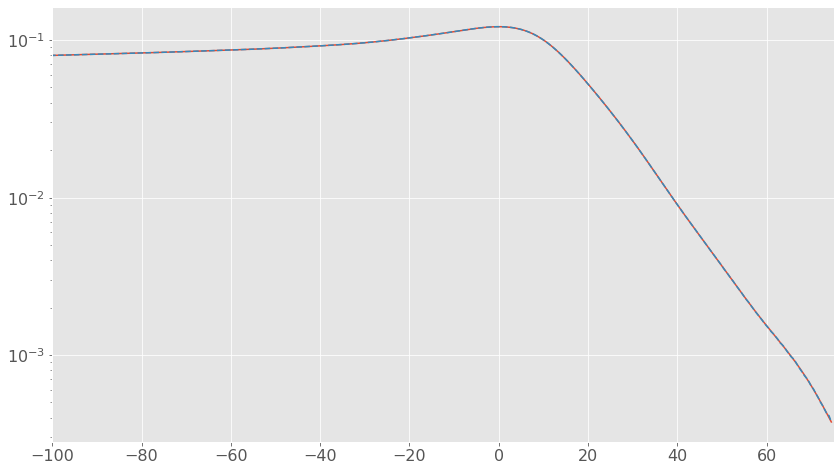

In [12]:
plt.figure(figsize=(14, 8))
plt.plot(times, np.abs(wf.h22))
plt.plot(times, np.abs(h[0]), ls='--')
plt.xlim(-100, 75)
plt.yscale('log')

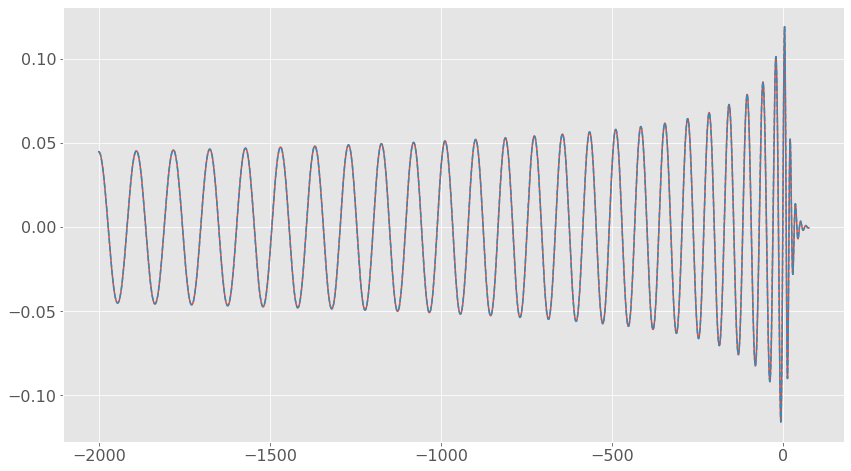

In [13]:
plt.figure(figsize=(14, 8))
plt.plot(times, np.real(wf.h22))
plt.plot(times, np.real(h[0]), ls='--')
# plt.xlim(-100, 75)

# bounds plot

In [14]:
a=predict_wave(0,1)

In [15]:
a

(array([[ 0.11422517-0.00028235j,  0.11424191+0.00247076j,
          0.11412307+0.00465945j, ..., -0.00212637+0.00105142j,
         -0.00224665+0.00061232j, -0.00223868-0.00016482j]]),
 array([[0.11422551, 0.11426862, 0.11421815, ..., 0.00237212, 0.0023286 ,
         0.00224474]]),
 array([[ 2.47183042e-03, -2.16240836e-02, -4.08055876e-02, ...,
         -1.66045198e+02, -1.66238328e+02, -1.66577901e+02]]))

In [16]:
def bound_plot(q, n_num):
    
    
    ns = np.linspace(0, 3, n_num)
    
    h_amp_phase = np.array([predict_wave(n=n, q=q) for n in ns])
    hs = h_amp_phase[:,0,0]
    amps = np.real(h_amp_phase[:,1,0])
    phases = np.real(h_amp_phase[:,2,0])

    plt.figure(figsize=(24, 8))
    plt.subplot(1, 2, 1)
    for amp in amps:
        plt.plot(times, amp)
        
        
    amp_min = np.min(amps,axis=0)
    amp_max = np.max(amps,axis=0)
    amp_mean = np.mean(amps,axis=0)
        
    plt.subplot(1, 2, 2)
    for amp in amps:
        plt.plot(times, amp, c='C0', alpha=1, lw=1)
        
    plt.plot(times, amp_mean, c='k', lw=3)
    plt.fill_between(times, y1=amp_min, y2=amp_max, color='k', alpha=0.5, lw=3)
    
    plt.xlim(-50, 50)

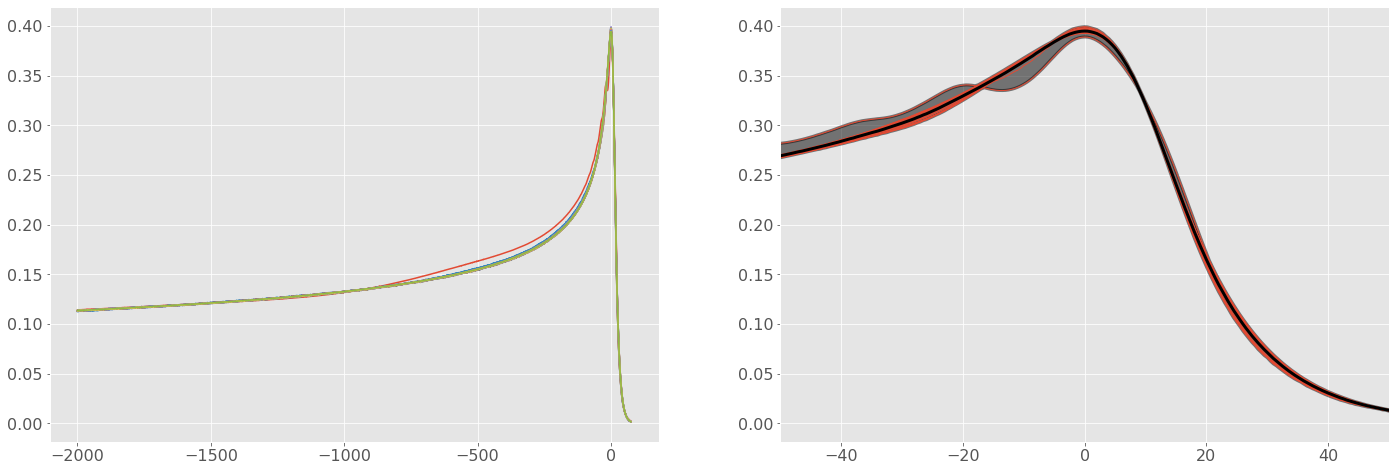

In [17]:
bound_plot(q=1, n_num=20)

# interactive plot

In [18]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(n, q, name):
    plt.figure(2, figsize=(20, 12))
    x = np.linspace(-10, 10, num=1000)
    h, amp, phase = predict_wave(n=n, q=q)
    
    approxs = ['IMRPhenomC', 'IMRPhenomD', 'SEOBNRv4_opt']
    wfs = {approx: wispy.waveutils.gen_model_waveforms(approx=approx, qlist=[q], dt=dt, t_min=t_min, t_max=t_max, nrfiles=None)[0] for approx in approxs}

    if name == 'h':
        plt.plot(times, np.real(h[0]), ls='--', label='fuzzy model')
        for k,wf in wfs.items():
            plt.plot(times, np.real(wf.h22), label=k)
        plt.ylim(-0.4,0.4)
    elif name == 'amp':
        plt.plot(times, amp[0], ls='--', label='fuzzy model')
        for k,wf in wfs.items():
            plt.plot(times, wf.amp, label=k)
        plt.ylim(1e-3,0.4)
#         plt.yscale('log')
    elif name == 'phase':
        plt.plot(times, phase[0], ls='--', label='fuzzy model')
        for k,wf in wfs.items():
            plt.plot(times, wf.phase, label=k)
        plt.ylim(-20,0)

    plt.xlim(-200, 100)
#     plt.xlim(-50, 20)
    plt.legend()
    plt.show()

interactive_plot = interactive(f, n=(0., 3., 0.01), q=(1, 10, 0.5), name=['amp','phase','h'])
output = interactive_plot.children[-1]
# output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.5, description='n', max=3.0, step=0.01), FloatSlider(value=5.0, desc…

# using pycbc

In [19]:
import pycbc.filter
import pycbc.types

In [20]:
mtot = 100
dt_s = phenom.MtoS(dt, mtot)
epoch_s = phenom.MtoS(t_min, mtot)

In [21]:
h1 = pycbc.types.TimeSeries(np.real(wf.h22), delta_t=dt_s, epoch=epoch_s)

In [22]:
h2 = pycbc.types.TimeSeries(np.real(h[0]), delta_t=dt_s, epoch=epoch_s)

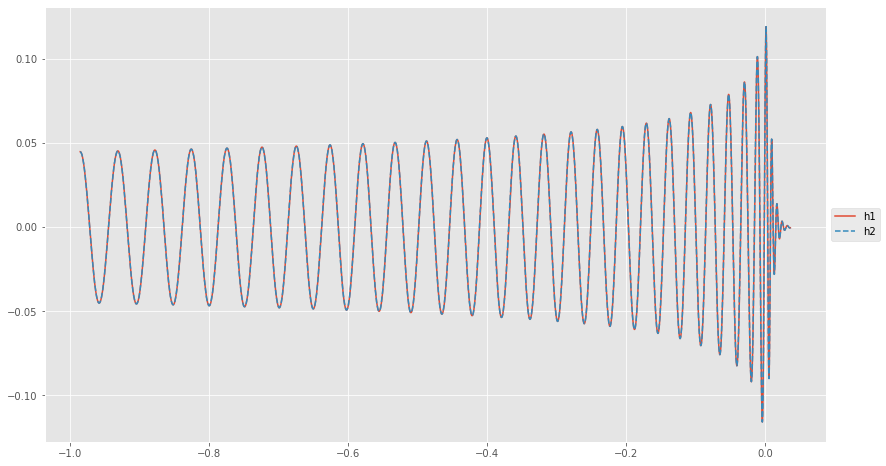

In [23]:
plt.figure(figsize=(14, 8))
plt.plot(h1.sample_times, h1, label='h1')
plt.plot(h2.sample_times, h2, label='h2', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [24]:
pycbc.filter.match(h1, h2)

(0.9999717962455216, 0)

In [25]:
pycbc.filter.overlap(h1, h2)

0.9999652203451873

In [26]:
h1_fs = h1.to_frequencyseries()
h2_fs = h2.to_frequencyseries()

In [27]:
pycbc.filter.match(h1_fs, h2_fs)

(0.9999717962455216, 0)

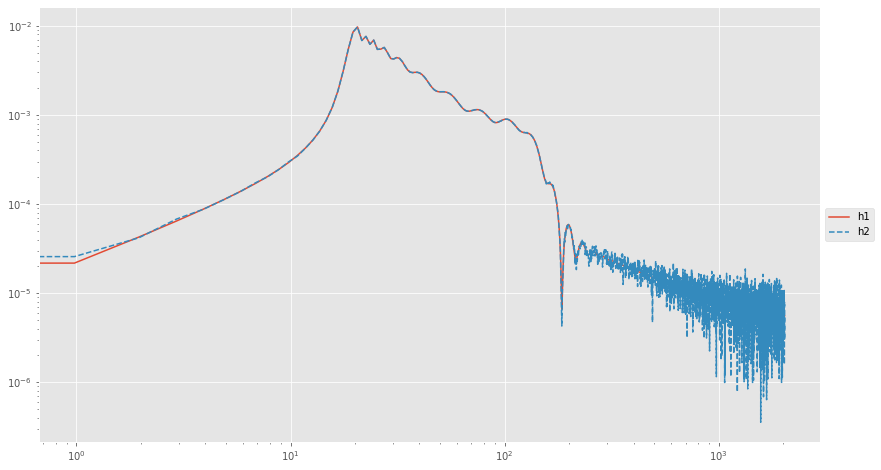

In [28]:
plt.figure(figsize=(14, 8))
plt.plot(h1_fs.sample_frequencies, np.abs(h1_fs), label='h1')
plt.plot(h2_fs.sample_frequencies, np.abs(h2_fs), label='h2', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
